In [2]:
import os
import matplotlib.pyplot as plt
import seaborn as sns
import io
import pandas as pd
import torch
from torchvision import transforms, datasets
from torch.utils.data import Dataset, DataLoader,random_split 
from torchvision.datasets import ImageFolder
import torch.nn as nn
import torch.optim as optim
from PIL import Image
import numpy as np

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.cuda.is_available()

c:\Users\walam\anaconda3\lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


True

In [48]:
import torch
print(torch.__version__)          # Should show `2.5.1+cu121`
print(torch.cuda.is_available())  # Should return `True`
print(torch.cuda.get_device_name(0))  # Should show your GPU (RTX 3050)

2.5.1+cu121
True
NVIDIA GeForce RTX 3050 6GB Laptop GPU


c:\Users\walam\anaconda3\lib\site-packages\seaborn\_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)
c:\Users\walam\anaconda3\lib\site-packages\seaborn\_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


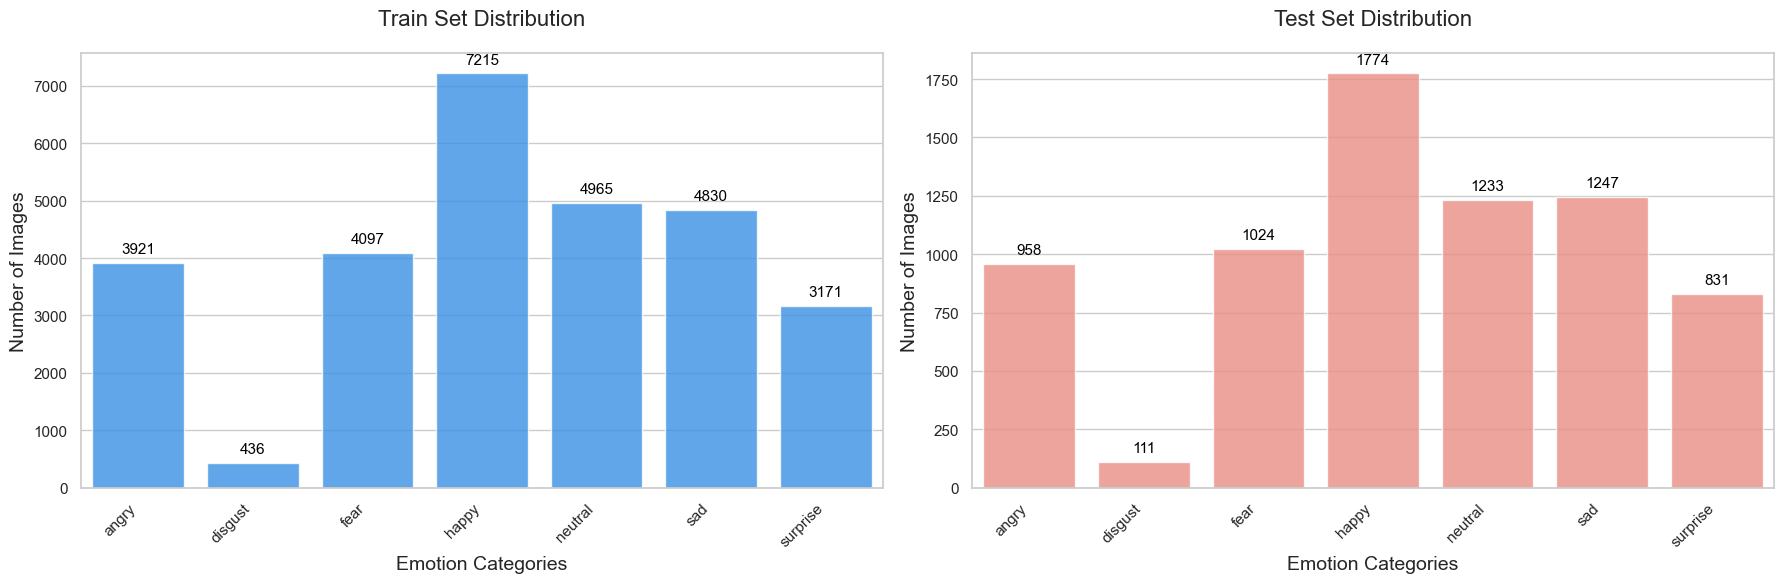


=== Dataset Statistics ===
Total train images: 28635
Total test images: 7178
Total images in dataset: 35813

Train Set Distribution:
angry: 3921 images (13.7%)
disgust: 436 images (1.5%)
fear: 4097 images (14.3%)
happy: 7215 images (25.2%)
neutral: 4965 images (17.3%)
sad: 4830 images (16.9%)
surprise: 3171 images (11.1%)

Test Set Distribution:
angry: 958 images (13.3%)
disgust: 111 images (1.5%)
fear: 1024 images (14.3%)
happy: 1774 images (24.7%)
neutral: 1233 images (17.2%)
sad: 1247 images (17.4%)
surprise: 831 images (11.6%)


In [49]:
# EDA for Emotion Recognition Dataset - Separate Plots
import os
import matplotlib.pyplot as plt
import seaborn as sns

# Set up paths
data_dir = "C:/Users/walam/Downloads/facial expressions"  # Your root directory
train_dir = os.path.join(data_dir, "train")
test_dir = os.path.join(data_dir, "test")

# Get emotion categories
emotions = sorted(os.listdir(train_dir))

# Count images per emotion
train_counts = {emotion: len(os.listdir(os.path.join(train_dir, emotion))) for emotion in emotions}
test_counts = {emotion: len(os.listdir(os.path.join(test_dir, emotion))) for emotion in emotions}

# Calculate totals
total_train = sum(train_counts.values())
total_test = sum(test_counts.values())

# Set style
sns.set(style="whitegrid")
plt.figure(figsize=(18, 6))

# --------------------------
# First Plot - Train Distribution
# --------------------------
plt.subplot(1, 2, 1)
ax1 = sns.barplot(x=list(train_counts.keys()), y=list(train_counts.values()), 
                color="dodgerblue", alpha=0.8)
plt.title("Train Set Distribution", fontsize=16, pad=20)
plt.xlabel("Emotion Categories", fontsize=14)
plt.ylabel("Number of Images", fontsize=14)
plt.xticks(rotation=45, ha='right')

# Add annotations
for p in ax1.patches:
    ax1.annotate(f'{int(p.get_height())}', 
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='bottom', 
                fontsize=11, color='black',
                xytext=(0, 5), 
                textcoords='offset points')

# --------------------------
# Second Plot - Test Distribution
# --------------------------
plt.subplot(1, 2, 2)
ax2 = sns.barplot(x=list(test_counts.keys()), y=list(test_counts.values()), 
                color="salmon", alpha=0.8)
plt.title("Test Set Distribution", fontsize=16, pad=20)
plt.xlabel("Emotion Categories", fontsize=14)
plt.ylabel("Number of Images", fontsize=14)
plt.xticks(rotation=45, ha='right')

# Add annotations
for p in ax2.patches:
    ax2.annotate(f'{int(p.get_height())}', 
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='bottom', 
                fontsize=11, color='black',
                xytext=(0, 5), 
                textcoords='offset points')

plt.tight_layout()
plt.show()

# Print statistics
print("\n=== Dataset Statistics ===")
print(f"Total train images: {total_train}")
print(f"Total test images: {total_test}")
print(f"Total images in dataset: {total_train + total_test}\n")

print("Train Set Distribution:")
for emotion, count in train_counts.items():
    print(f"{emotion}: {count} images ({count/total_train*100:.1f}%)")

print("\nTest Set Distribution:")
for emotion, count in test_counts.items():
    print(f"{emotion}: {count} images ({count/total_test*100:.1f}%)")

In [50]:

class ImageDataSet(Dataset):
    def __init__(self, folder_path):
        # Use ImageFolder to get all image paths and labels
        self.dataset = ImageFolder(root=folder_path, loader=self._custom_loader)
        self.class_names = self.dataset.classes
        self.class_to_idx = self.dataset.class_to_idx
        self.samples = self.dataset.samples  # List of (image_path, label)

        # Default transform for all other classes
        self.default_transform = transforms.Compose([
            transforms.Resize((256,256)),
            transforms.ToTensor(),
            transforms.Normalize((0.5,), (0.5,))
        ])

        # Custom transform for "disgust"
        self.disgust_transform = transforms.Compose([
            transforms.Resize((256,256)),
            transforms.RandomHorizontalFlip(),
            transforms.RandomRotation(10),
            transforms.ColorJitter(brightness=0.2, contrast=0.2),
            transforms.ToTensor(),
            transforms.Normalize((0.5,), (0.5,))
        ])

    def _custom_loader(self, path):
        """Custom image loader using PIL"""
        return Image.open(path).convert("RGB")

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        img_path, label = self.samples[idx]
        image = self._custom_loader(img_path)
        class_name = self.class_names[label]

        # Apply different transforms based on class
        if class_name == "disgust":
            image = self.disgust_transform(image)
        else:
            image = self.default_transform(image)

        return image, label

    def get_splits(self, val_ratio=0.2, seed=42):
        """
        Split the dataset into training and validation sets.
        """
        total_len = len(self)
        val_size = round(val_ratio * total_len)
        train_size = total_len - val_size
        generator = torch.Generator().manual_seed(seed)
        return random_split(self, [train_size, val_size], generator=generator)

        

In [51]:

def prepare_data(folder_path) :
    dataset = ImageDataSet(folder_path)
    train , validation = dataset.get_splits() 
    train_dl = DataLoader(train, batch_size=32, shuffle=True)
    val_dl = DataLoader(validation, batch_size=32, shuffle=False)
    return train_dl , val_dl


In [52]:
train_loader ,  valid_loader = prepare_data("C:/Users/walam/Downloads/facial expressions/train")
train_N = len(train_loader.dataset)
valid_N = len(valid_loader.dataset)

In [53]:
IMG_HEIGHT = 256
IMG_WIDTH = 256
IMG_CHS = 3  
n_classes = 7
kernel_size = 3
flattened_img_size =  100 * 8 * 8

model = nn.Sequential(
    nn.Conv2d(IMG_CHS, 25, kernel_size, stride=1, padding=1),  # 25 x 256 x 256
    nn.BatchNorm2d(25),
    nn.ReLU(),
    nn.MaxPool2d(2, stride=2),  # 25 x 128 x128
    # Second convolution
    nn.Conv2d(25, 50, kernel_size, stride=1, padding=1),  # 50 x 128 x 128
    nn.BatchNorm2d(50),
    nn.ReLU(),
    nn.Dropout(.2),
    nn.MaxPool2d(2, stride=2),  # 50 x 64 x 64
    # Third convolution
    nn.Conv2d(50, 75, kernel_size, stride=1, padding=1),  #  75x 64 x 64
    nn.BatchNorm2d(75),
    nn.ReLU(),
    nn.MaxPool2d(2, stride=2),  # 75 x 32 x 32 

    nn.Conv2d(75, 100, kernel_size, stride=1, padding=1),  #  100x 32 x 32
    nn.BatchNorm2d(100),
    nn.ReLU(),
    nn.Dropout(.3),
    nn.MaxPool2d(2, stride=2),  # 100 x 16 x 16

    nn.Conv2d(100, 100, kernel_size, stride=1, padding=1),  #  100x 16 x 16
    nn.BatchNorm2d(100),
    nn.ReLU(),
    nn.MaxPool2d(2, stride=2),  # 100 x 8 x 8

    # Flatten to Dense
    nn.Flatten(),
    nn.Linear(flattened_img_size, 4096),
    nn.Dropout(.3),
    nn.ReLU(),
    nn.Linear(4096, 4096),
    nn.Dropout(.4),
    nn.ReLU(),
    nn.Linear(4096, n_classes)
)

In [54]:
model = model.to(device)  # Less aggressive optimization

In [55]:
# Define optimizer and loss function
optimizer = optim.Adam(model.parameters(), lr=0.05)
loss_function = nn.CrossEntropyLoss()

In [56]:
def get_batch_accuracy(output, labels, dataset_size):
    _, predicted = torch.max(output, 1)  # Get predicted class labels
    correct = (predicted == labels).sum().item()
    accuracy = correct / dataset_size
    return accuracy


In [57]:
def validate():
    model.eval()
    total_loss = 0
    total_accuracy = 0
    total_batches = len(valid_loader)

    with torch.no_grad():
        for x, y in valid_loader:
            x = x.to(device)
            y = y.to(device)
            output = model(x)

            batch_loss = loss_function(output, y)
            total_loss += batch_loss.item()

            # Calculate accuracy for the batch
            total_accuracy += get_batch_accuracy(output, y, valid_N)

    avg_loss = total_loss / total_batches
    avg_accuracy = total_accuracy / total_batches
    print(f'Valid - Loss: {avg_loss:.4f} Accuracy: {avg_accuracy:.4f}')


In [58]:
def train():
    model.train()
    total_loss = 0
    total_accuracy = 0
    total_batches = len(train_loader)

    for x, y in train_loader:
        x = x.to(device)
        y = y.to(device)
        optimizer.zero_grad()

        output = model(x)
        batch_loss = loss_function(output, y)
        batch_loss.backward()
        optimizer.step()

        total_loss += batch_loss.item()

        # Calculate accuracy for the batch
        total_accuracy += get_batch_accuracy(output, y, train_N)

    avg_loss = total_loss / total_batches
    avg_accuracy = total_accuracy / total_batches
    print(f'Train - Loss: {avg_loss:.4f} Accuracy: {avg_accuracy:.4f}')


In [59]:
epochs = 20

for epoch in range(epochs):
    print('Epoch: {}'.format(epoch))
    train()
    validate()

Epoch: 0
Train - Loss: 400.4930 Accuracy: 0.0003
Valid - Loss: 1.8107 Accuracy: 0.0014
Epoch: 1
Train - Loss: 1.9392 Accuracy: 0.0004
Valid - Loss: 1.8136 Accuracy: 0.0014
Epoch: 2
Train - Loss: 1.8681 Accuracy: 0.0003
Valid - Loss: 1.8105 Accuracy: 0.0014
Epoch: 3
Train - Loss: 1.9220 Accuracy: 0.0003
Valid - Loss: 1.8097 Accuracy: 0.0014
Epoch: 4


KeyboardInterrupt: 

In [ ]:
import torch

print(f"PyTorch Version: {torch.__version__}")
print(f"CUDA Available: {torch.cuda.is_available()}")  # Should return True
print(f"GPU Device: {torch.cuda.get_device_name(0)}")  # Should show "NVIDIA GeForce RTX 3050"

PyTorch Version: 2.5.1+cu121
CUDA Available: True
GPU Device: NVIDIA GeForce RTX 3050 6GB Laptop GPU


In [3]:
torch._dynamo.config.suppress_errors = True
torch._dynamo.reset()

In [ ]:
# Corrected prepare_data function (should be outside the class)
def prepare_data(folder_path):
    dataset = ImageDataSet(folder_path)
    train, validation = dataset.get_splits() 
    train_dl = DataLoader(train, batch_size=32, shuffle=True)
    val_dl = DataLoader(validation, batch_size=32, shuffle=False)
    return train_dl, val_dl

# Correct path (remove leading slash on Windows)
train_loader, valid_loader = prepare_data("C:/Users/walam/Downloads/facial expressions/train")
train_N = len(train_loader.dataset)
valid_N = len(valid_loader.dataset)

# Correct accuracy calculation
def get_batch_accuracy(output, labels):
    _, predicted = torch.max(output, 1)
    correct = (predicted == labels).sum().item()
    accuracy = correct / labels.size(0)  # Divide by batch size
    return accuracy

# Improved training and validation functions
def train():
    model.train()
    total_loss = 0
    total_correct = 0
    total_samples = 0

    for x, y in train_loader:
        x = x.to(device)
        y = y.to(device)
        optimizer.zero_grad()

        output = model(x)
        batch_loss = loss_function(output, y)
        batch_loss.backward()
        optimizer.step()

        total_loss += batch_loss.item() * x.size(0)
        total_correct += (torch.max(output, 1)[1] == y).sum().item()
        total_samples += y.size(0)

    avg_loss = total_loss / total_samples
    avg_accuracy = total_correct / total_samples
    print(f'Train - Loss: {avg_loss:.4f} Accuracy: {avg_accuracy:.4f}')
    return avg_loss, avg_accuracy

def validate():
    model.eval()
    total_loss = 0
    total_correct = 0
    total_samples = 0

    with torch.no_grad():
        for x, y in valid_loader:
            x = x.to(device)
            y = y.to(device)
            output = model(x)

            batch_loss = loss_function(output, y)
            total_loss += batch_loss.item() * x.size(0)
            total_correct += (torch.max(output, 1)[1] == y).sum().item()
            total_samples += y.size(0)

    avg_loss = total_loss / total_samples
    avg_accuracy = total_correct / total_samples
    print(f'Valid - Loss: {avg_loss:.4f} Accuracy: {avg_accuracy:.4f}')
    return avg_loss, avg_accuracy

# Training loop with model saving
best_val_accuracy = 0
for epoch in range(epochs):
    print(f'Epoch: {epoch+1}/{epochs}')
    train_loss, train_acc = train()
    val_loss, val_acc = validate()
    
    # Save best model
    if val_acc > best_val_accuracy:
        best_val_accuracy = val_acc
        torch.save(model.state_dict(), 'best_model.pth')
        print(f'New best model saved with accuracy: {best_val_accuracy:.4f}')

Epoch: 1/20


RuntimeError: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same